In [17]:
# Import required libraries
from abc import ABC, abstractmethod
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [41]:
# Interface for MNIST classifiers
class MnistClassifierInterface(ABC):
    @abstractmethod
    def train(self):
        pass

    @abstractmethod
    def predict(self, X):
        pass

# Implementation for Random Forest
class MnistRFClassifier(MnistClassifierInterface):
    def __init__(self):
        # Load data
        (self.X_train, self.y_train), (self.X_test, self.y_test) = mnist.load_data()
        # Reshape 28x28 images into 1D arrays (784 features)
        self.X_train = self.X_train.reshape(self.X_train.shape[0], -1)
        self.X_test = self.X_test.reshape(self.X_test.shape[0], -1)
        # Normalize pixel values (divide by 255)
        self.X_train = self.X_train / 255.0
        self.X_test = self.X_test / 255.0
        self.model = None

    def train(self):
        # Set the pre-determined best parameters
        self.model = RandomForestClassifier(
            n_estimators=200,
            min_samples_leaf=1,
            min_samples_split=2,
            random_state=42,
            n_jobs=-1
        )
        self.model.fit(self.X_train, self.y_train)

        # Evaluate the model on the test set
        y_pred = self.model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        print(f"Test Accuracy: {accuracy:.4f}")
        print("\nClassification Report:\n", classification_report(self.y_test, y_pred))

        # Identify indices of misclassified samples
        misclassified_idx = np.where(self.y_test != y_pred)[0]
        misclassified_dict = {}
        for idx in misclassified_idx:
            true_label = self.y_test[idx]
            pred_label = y_pred[idx]
            if true_label not in misclassified_dict:
                misclassified_dict[true_label] = []
            misclassified_dict[true_label].append((idx, pred_label))
        sorted_misclassified = sorted(misclassified_dict.items(), key=lambda x: len(x[1]))
        total_misclassified = 0
        for true_label, errors in sorted_misclassified:
            print(f"Class {true_label}: misclassified {len(errors)} examples")
            total_misclassified += len(errors)
        print(f"Total misclassified samples: {total_misclassified}")

    def predict(self, X):
        # Ensure the input data has the correct shape (28x28 -> 784)
        if X.ndim == 3:  # If X has shape (num_samples, 28, 28)
            X = X.reshape(X.shape[0], -1)

        # Normalize pixel values to the range [0,1]
        X = X / 255.0

        predictions = self.model.predict(X)
    
        # Display predictions in a readable format
        print("Predicted Labels:")
        print(", ".join(map(str, predictions)))
    
        return predictions 

# Placeholder for NN (methods are left empty as data processing may differ)
class MnistNNClassifier(MnistClassifierInterface):
    def __init__(self):
        # Load data
        (self.X_train, self.y_train), (self.X_test, self.y_test) = mnist.load_data()
        # Normalize pixel values
        # Note: Here we do not reshape to (28,28,1) yet, because for augmentation and model training we will work with flattened images.
        self.X_train = self.X_train / 255.0
        self.X_test = self.X_test / 255.0
        self.model = None

    def train(self):
        # Preprocess: Flatten images into 1D vectors
        x_train = self.X_train.reshape(-1, 28 * 28)
        x_test = self.X_test.reshape(-1, 28 * 28)
        
        # Select classes (all digits in a specified order)
        selected_classes = [5, 8, 9, 1, 2, 3, 4, 6, 7, 0]
        indices = np.where(np.isin(self.y_train, selected_classes))[0]
        x_selected = x_train[indices]   # Selected images
        y_selected = self.y_train[indices]  # Corresponding labels

        # Expand selected images to 28x28x1 (for augmentation)
        x_selected = x_selected.reshape(-1, 28, 28, 1)

        # Configure the generator for augmentation
        datagen = ImageDataGenerator(
            rotation_range=15,       # Random rotation
            width_shift_range=0.1,   # Horizontal shift
            height_shift_range=0.1,  # Vertical shift
            zoom_range=0.1,          # Scaling
            shear_range=0.1,         # Shearing
            fill_mode='nearest'      # Pixel filling after transformation
        )

        # Generate augmented images
        augmented_images = []
        augmented_labels = []
        num_augmented = len(x_selected)  # Number of images to augment

        for i in range(num_augmented):
            img = x_selected[i]
            img = np.expand_dims(img, axis=0)  # Add batch dimension
            it = datagen.flow(img, batch_size=1)
            # Create 3 augmented copies for each image
            for _ in range(3):
                augmented_img = next(it)[0]
                augmented_images.append(augmented_img)
                augmented_labels.append(y_selected[i])

        # Convert augmented data to arrays
        augmented_images = np.array(augmented_images)
        augmented_labels = np.array(augmented_labels)

        # Since x_train is flattened, reshape augmented images accordingly
        augmented_images_flat = augmented_images.reshape(-1, 28 * 28)
        x_train = np.concatenate((x_train, augmented_images_flat))
        y_train = np.concatenate((self.y_train, augmented_labels))

        # Build Feed-Forward Neural Network
        model = keras.Sequential([
            layers.Input(shape=(28 * 28,)),
            layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.Dropout(0.1),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.1),
            layers.Dense(64, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])

        # Configure learning rate schedule and optimizer
        initial_learning_rate = 0.001
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True)
        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

        model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        # Train the model
        history = model.fit(x_train, y_train, epochs=15, batch_size=64,
                            validation_data=(x_test, self.y_test))

        # Plot training and validation accuracy and loss
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Evaluate the model on the test set
        y_pred_probs = model.predict(x_test)
        y_pred = np.argmax(y_pred_probs, axis=1)
        print(classification_report(self.y_test, y_pred))

        # Identify misclassified samples
        misclassified_idx = np.where(self.y_test != y_pred)[0]
        misclassified_dict = {}
        for idx in misclassified_idx:
            true_label = self.y_test[idx]
            pred_label = y_pred[idx]
            if true_label not in misclassified_dict:
                misclassified_dict[true_label] = []
            misclassified_dict[true_label].append((idx, pred_label))
        sorted_misclassified = sorted(misclassified_dict.items(), key=lambda x: len(x[1]))
        total_errors = 0
        for true_label, errors in sorted_misclassified:
            print(f"Class {true_label}: {len(errors)} misclassified samples")
            total_errors += len(errors)
        print(f"Total misclassified samples: {total_errors}")

        # Construct the confusion matrix
        y_pred = model.predict(x_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        cm = confusion_matrix(self.y_test, y_pred_classes)

        # Visualize the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=np.arange(10), yticklabels=np.arange(10))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

        self.model = model  # Save the trained model

    def predict(self, X):
        # Ensure the input data has the correct shape (28x28 -> 784)
        if X.ndim == 3:  # If X has shape (num_samples, 28, 28)
            X = X.reshape(X.shape[0], 28 * 28).astype('float32') / 255.0
        elif X.ndim == 2:  # If a single image (28x28) is passed
            X = X.reshape(1, 28 * 28).astype('float32') / 255.0
    
        # Make predictions (returns probabilities)
        y_pred_probs = self.model.predict(X)
    
        # Convert probabilities to class labels
        y_pred_classes = np.argmax(y_pred_probs, axis=1)
    
        # Display formatted output
        print("Predicted Labels:", ", ".join(map(str, y_pred_classes)))
    
        return y_pred_classes


# Placeholder for CNN (methods are left empty as data processing may differ)
class MnistCNNClassifier(MnistClassifierInterface):
    def __init__(self):
        # Load data
        (self.X_train, self.y_train), (self.X_test, self.y_test) = mnist.load_data()
        
        # Normalize pixel values to be between 0 and 1 and reshape for CNN
        self.X_train = self.X_train.reshape((-1, 28, 28, 1)).astype('float32') / 255.0
        self.X_test = self.X_test.reshape((-1, 28, 28, 1)).astype('float32') / 255.0

        # One-hot encode the labels
        self.y_train = to_categorical(self.y_train, num_classes=10)
        self.y_test = to_categorical(self.y_test, num_classes=10)
        
        self.model = None

    def train(self):
        # Define the CNN model exactly as provided
        self.model = models.Sequential([
            layers.Input(shape=(28, 28, 1)),

            # First convolutional block
            layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Second convolutional block
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),

            # Fully connected layers
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.25),
            layers.Dense(10, activation='softmax')
        ])

        # Compile the model
        self.model.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

        # Print the model summary
        #self.model.summary()

        # Train the model
        history = self.model.fit(self.X_train, self.y_train, epochs=10, batch_size=64,
                                 validation_data=(self.X_test, self.y_test))

        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(self.X_test, self.y_test)
        print(f'Test accuracy: {test_acc:.4f}')

        # --- Evaluation Code ---
        # Make predictions on the test set
        y_pred_probs = self.model.predict(self.X_test)  # Get probability outputs
        y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
        y_true = np.argmax(self.y_test, axis=1)  # Convert one-hot labels to class indices

        # Find indices of misclassified samples
        misclassified_idx = np.where(y_true != y_pred_classes)[0]

        # Create a dictionary to store misclassified examples
        misclassified_dict = {}
        for idx in misclassified_idx:
            true_label, pred_label = y_true[idx], y_pred_classes[idx]
            misclassified_dict.setdefault(true_label, []).append((idx, pred_label))

        # Sort misclassified classes by the number of misclassifications
        sorted_misclassified = sorted(misclassified_dict.items(), key=lambda x: len(x[1]))

        # Display misclassification statistics
        total_errors = sum(len(errors) for _, errors in sorted_misclassified)
        print("Misclassification Summary:")
        for true_label, errors in sorted_misclassified:
            print(f"Class {true_label}: {len(errors)} misclassified samples")
        print(f"Total misclassified samples: {total_errors}")

        # Construct and visualize the confusion matrix
        cm = confusion_matrix(y_true, y_pred_classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=np.arange(10), yticklabels=np.arange(10))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()


    def predict(self, X):
        # Ensure the input data has the correct shape (28x28 -> 28x28x1)
        if X.ndim == 3:  # If X has shape (num_samples, 28, 28)
            X = X.reshape((-1, 28, 28, 1)).astype('float32') / 255.0
        elif X.ndim == 2:  # If a single image (28x28) is passed
            X = X.reshape((1, 28, 28, 1)).astype('float32') / 255.0
    
        # Make predictions (returns probabilities)
        y_pred_probs = self.model.predict(X)
    
        # Convert probabilities to class labels
        y_pred_classes = np.argmax(y_pred_probs, axis=1)
    
        # Display formatted output
        print("Predicted Labels:", ", ".join(map(str, y_pred_classes)))
    
        return y_pred_classes

# Wrapper class that takes the algorithm name and uses the corresponding model
class MnistClassifier:
    def __init__(self, algorithm):
        self.algorithm = algorithm.lower()
        if self.algorithm == 'rf':
            self.model = MnistRFClassifier()
        elif self.algorithm == 'cnn':
            self.model = MnistCNNClassifier()
        elif self.algorithm == 'nn':
            self.model = MnistNNClassifier()
        else:
            raise ValueError("Invalid algorithm. Choose from 'cnn', 'rf', or 'nn'.")

    def train(self):
        self.model.train()

    def predict(self, X):
        return self.model.predict(X)




Epoch 1/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.8426 - loss: 0.6746 - val_accuracy: 0.9776 - val_loss: 0.1733
Epoch 2/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.9492 - loss: 0.2626 - val_accuracy: 0.9820 - val_loss: 0.1360
Epoch 3/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.9604 - loss: 0.2028 - val_accuracy: 0.9853 - val_loss: 0.1108
Epoch 4/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.9679 - loss: 0.1652 - val_accuracy: 0.9863 - val_loss: 0.0970
Epoch 5/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.9732 - loss: 0.1356 - val_accuracy: 0.9888 - val_loss: 0.0812
Epoch 6/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.9767 - loss: 0.1180 - val_accuracy: 0.9883 - val_loss: 0.0759
Epoch 7/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.9807 - loss: 0.1019 - val_accuracy: 0.9886 - val_loss: 0.0710
Epoch 8/15
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.9823 - loss: 0

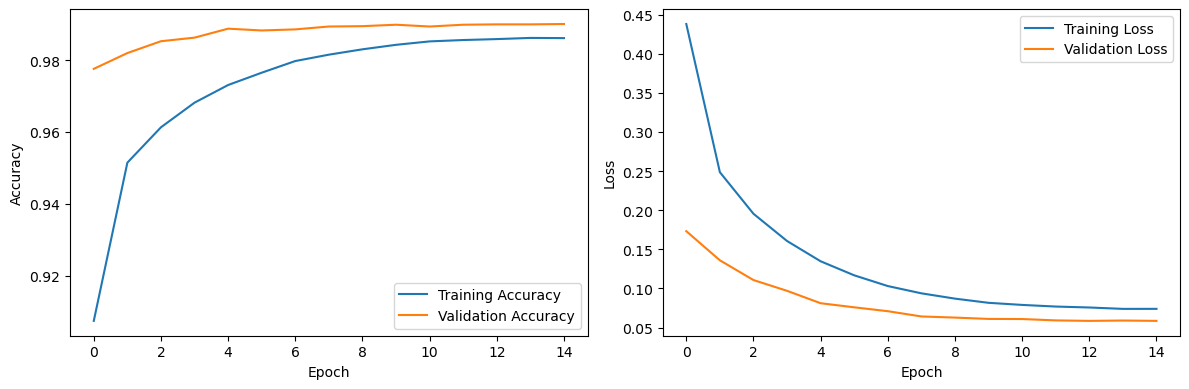

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Class 0: 3 misclassified samples
Class 1: 5 misclassified samples
Class 2: 6 misclassified samples
Class 3: 7 misclassified samples
Class 4: 8 misclassified samples
Class 7: 10 misclassified samples

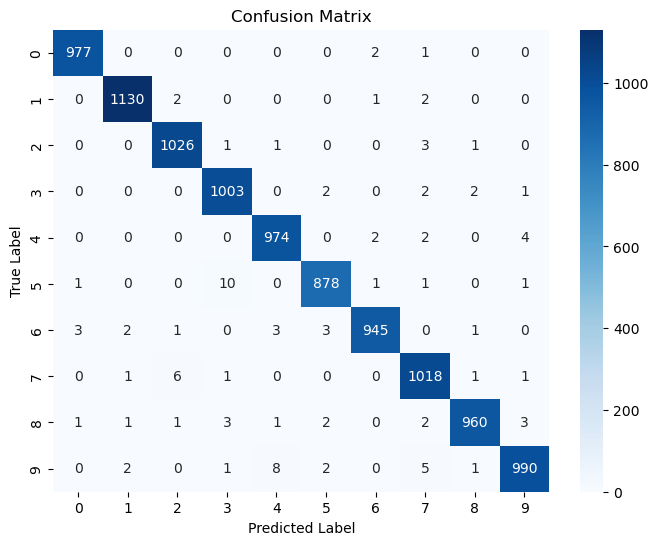

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
Predicted Labels: 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [42]:
# Create a classifier using the Random Forest algorithm
mnist_classifier = MnistClassifier('nn')
mnist_classifier.train()
# For prediction, you can use, for example, the test set:
predictions = mnist_classifier.predict(mnist_classifier.model.X_test)